In [3]:
!pip install statsmodels prophet


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
import pandas as pd

# Load the cleaned dataset from your outputs or prior notebook
loan_data_df = pd.read_csv("../data/exports/loan_data.csv") 
metrics_df = pd.read_csv("../outputs/metrics_df_segmented_labeled.csv") 

# Quick check
loan_data_df.head()


C:\Users\mahas\AppData\Local\Temp\ipykernel_73844\2398898892.py:4: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_df = pd.read_csv("../data/exports/loan_data.csv")


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,debt_settlement_flag,loan_default,customer_tenure,income_group,simulated_recency,product_segment,delinquency_flag,customer_id,default_probability,cohort_month
0,16000,16000,16000.0,36 months,19.91,593.89,E,E4,2 years,RENT,...,N,0,164,Mid,Old,Debt,0,20782,0.05,2011-11
1,17000,17000,17000.0,36 months,13.49,576.82,C,C1,1 year,OWN,...,N,0,164,Mid,Old,Other,0,20794,0.05,2011-11
2,15000,15000,15000.0,36 months,7.90,469.36,A,A4,2 years,OWN,...,N,0,158,Mid,Old,Debt,0,1183412,0.05,2012-05
3,20000,20000,19975.0,36 months,13.67,680.36,B,B5,1 year,MORTGAGE,...,N,0,159,Mid,Old,Debt,0,1183413,0.05,2012-04
4,4200,4200,4200.0,60 months,19.22,109.46,D,D5,7 years,MORTGAGE,...,N,0,159,Low,Old,Debt,0,1183414,0.05,2012-04


In [8]:
print(loan_data_df.columns.tolist())


['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 

In [6]:
# Parse date from issue_d
loan_data_df['issue_d'] = pd.to_datetime(loan_data_df['issue_d'], errors='coerce')

# extract the Month-Year as a string
loan_data_df['issue_month'] = loan_data_df['issue_d'].dt.to_period('M').astype(str)



C:\Users\mahas\AppData\Local\Temp\ipykernel_73844\624089364.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  loan_data_df['issue_d'] = pd.to_datetime(loan_data_df['issue_d'], errors='coerce')


In [7]:
repayment_ts = loan_data_df.groupby('issue_month')['total_pymnt'].sum().reset_index()
repayment_ts.columns = ['Month', 'Total_Repayment']
repayment_ts['Month'] = pd.to_datetime(repayment_ts['Month'])


In [8]:
loan_data_df['is_churned'] = loan_data_df['loan_status'].isin(['Charged Off', 'Default']).astype(int)
churn_ts = loan_data_df.groupby('issue_month')['is_churned'].mean().reset_index()
churn_ts.columns = ['Month', 'Churn_Rate']
churn_ts['Month'] = pd.to_datetime(churn_ts['Month'])


In [9]:
loan_data_df = loan_data_df.merge(
    metrics_df[['customer_id', 'Segment_Label']],
    on='customer_id',
    how='left'
)


In [10]:
print('loan_data_df:', 'customer_id' in loan_data_df.columns)
print('metrics_df:', 'customer_id' in metrics_df.columns)


loan_data_df: True
metrics_df: True


In [11]:
print(loan_data_df['Segment_Label'].isnull().mean())
print(loan_data_df[['customer_id', 'Segment_Label']].head())


0.0
   customer_id       Segment_Label
0        20782  Long-term Sleepers
1        20794  Long-term Sleepers
2      1183412  Long-term Sleepers
3      1183413  Long-term Sleepers
4      1183414  Long-term Sleepers


In [12]:
segment_ts = loan_data_df.groupby(['issue_month', 'Segment_Label'])['loan_amnt'].sum().reset_index()
segment_ts.columns = ['Month', 'Segment', 'Loan_Volume']
segment_ts['Month'] = pd.to_datetime(segment_ts['Month'])


23:51:35 - cmdstanpy - INFO - Chain [1] start processing
23:51:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mahas\FinSurf\venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


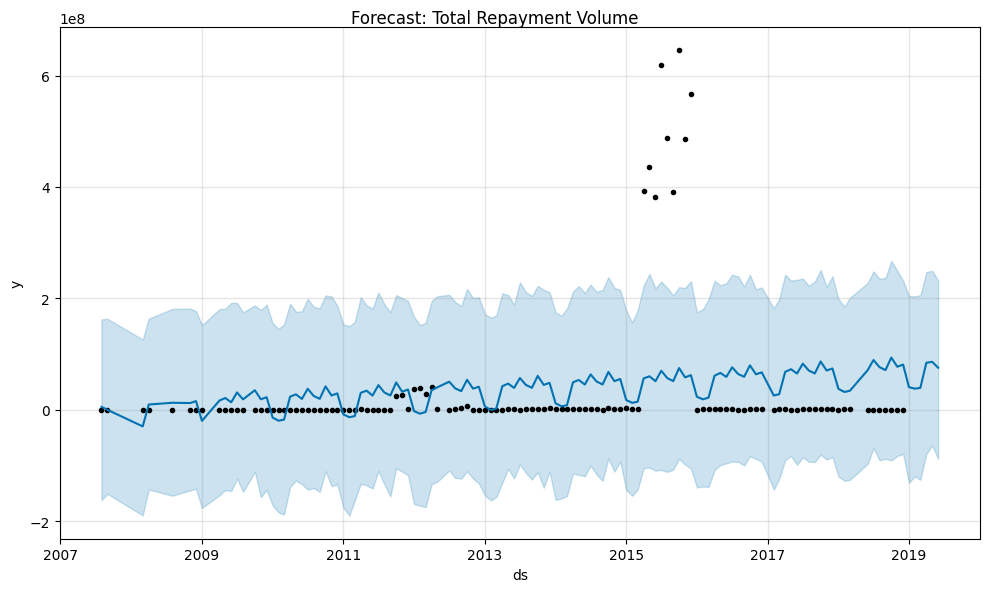

MAE: 81350061.21065421
RMSE: 81719804.79039317


In [13]:
#Forecast Total Repayment using Prophet

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare data
repayment_df = repayment_ts.copy()
repayment_df.columns = ['ds', 'y']  

# Model
model = Prophet()
model.fit(repayment_df)

# Create future dataframe
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)
fig.suptitle("Forecast: Total Repayment Volume")
fig.savefig("../outputs/forecast_total_repayment.png", bbox_inches='tight')
plt.show()

# Evaluate on last available months
y_true = repayment_df['y'][-6:]
y_pred = forecast['yhat'][-12:-6].values  

print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))


In [14]:
forecast.to_csv("../forecasts/prophet_total_repayment.csv", index=False)
repayment_df.to_csv("../actuals/actual_total_repayment.csv", index=False)


23:53:51 - cmdstanpy - INFO - Chain [1] start processing
23:53:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mahas\FinSurf\venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


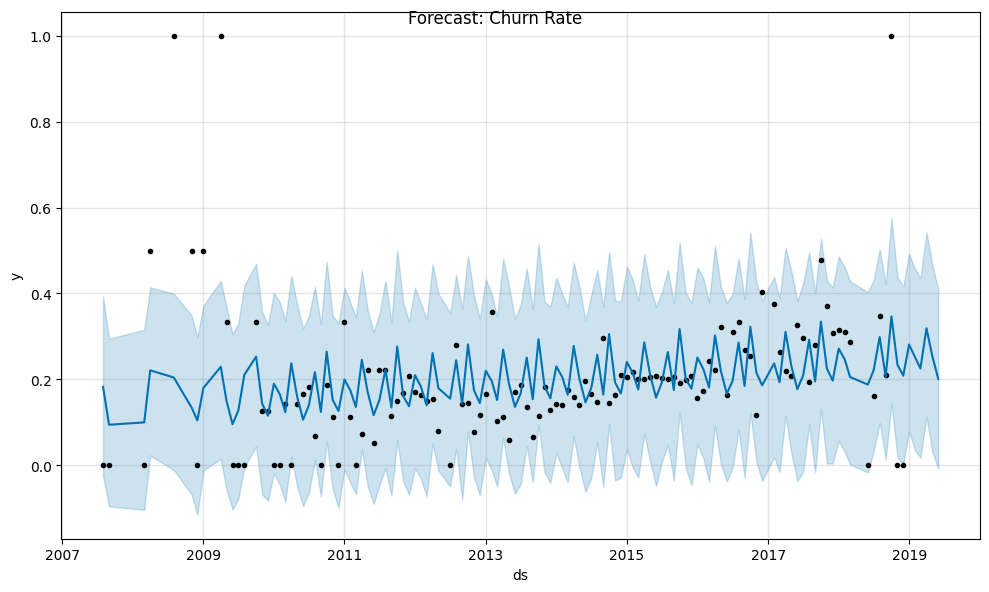

MAE: 0.20189183060427915
RMSE: 0.2975961094926899


In [16]:
#Forecast Churn Rate with Prophet

churn_df = churn_ts.copy()
churn_df.columns = ['ds', 'y']

model_churn = Prophet()
model_churn.fit(churn_df)

future_churn = model_churn.make_future_dataframe(periods=6, freq='M')
forecast_churn = model_churn.predict(future_churn)

fig = model_churn.plot(forecast_churn)
fig.suptitle("Forecast: Churn Rate")
fig.savefig("../outputs/forecast_churn_rate_overall.png", bbox_inches='tight')
plt.show()

# Accuracy check (last 6 months)
y_true = churn_df['y'][-6:]
y_pred = forecast_churn['yhat'][-12:-6].values

print("MAE:", mean_absolute_error(y_true, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))


In [17]:
forecast_churn.to_csv("../forecasts/prophet_churn_forecast.csv", index=False)
churn_df.to_csv("../actuals/actual_churn_rate.csv", index=False)


00:01:18 - cmdstanpy - INFO - Chain [1] start processing
00:01:18 - cmdstanpy - INFO - Chain [1] done processing


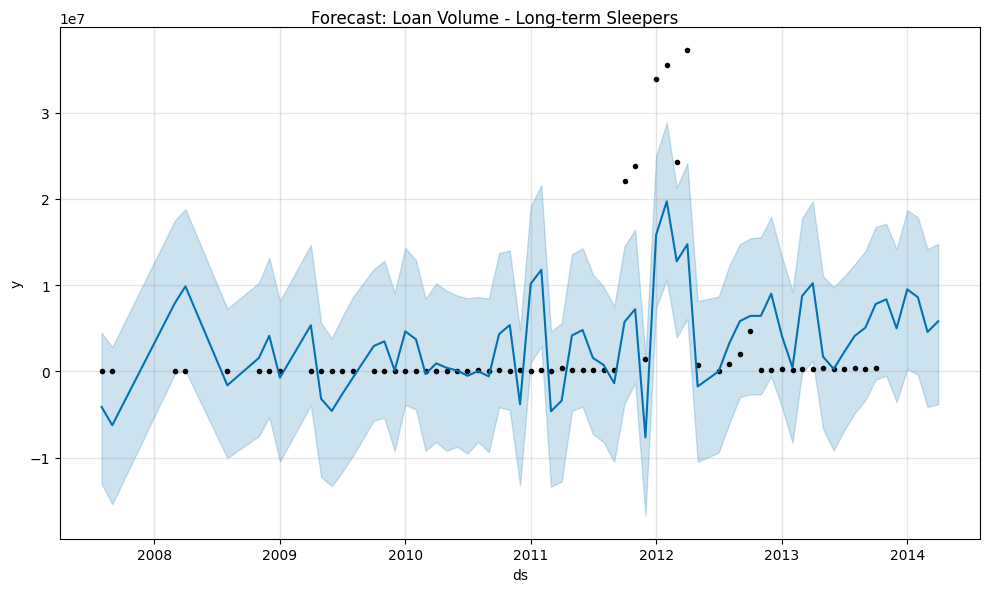

00:01:19 - cmdstanpy - INFO - Chain [1] start processing


Segment: Long-term Sleepers
MAE: 3203264.1264888854
RMSE: 4028522.9352760077


00:01:19 - cmdstanpy - INFO - Chain [1] done processing


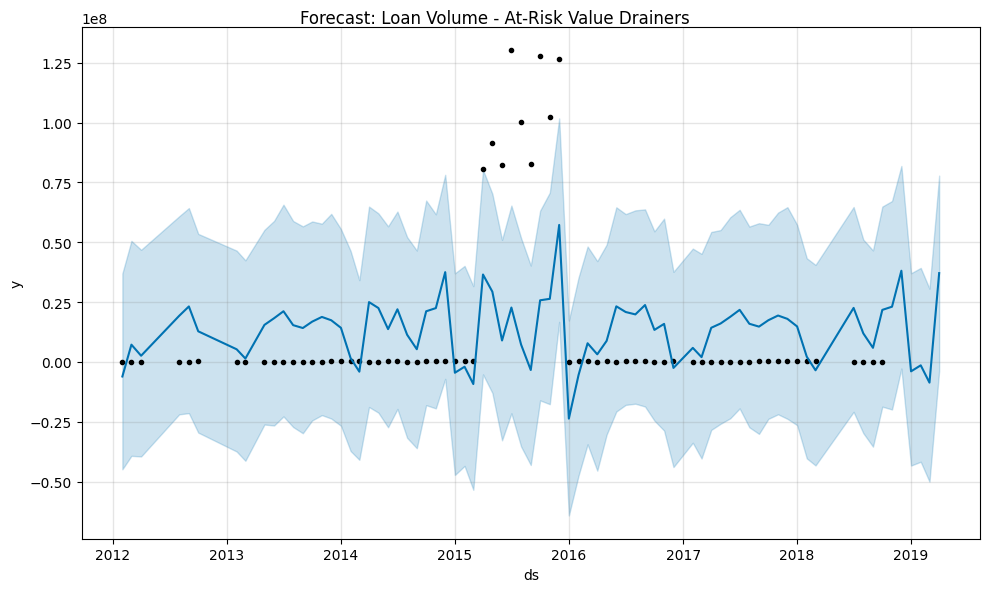

00:01:19 - cmdstanpy - INFO - Chain [1] start processing


Segment: At-Risk Value Drainers
MAE: 11242445.926858375
RMSE: 13963611.43353123


00:01:20 - cmdstanpy - INFO - Chain [1] done processing


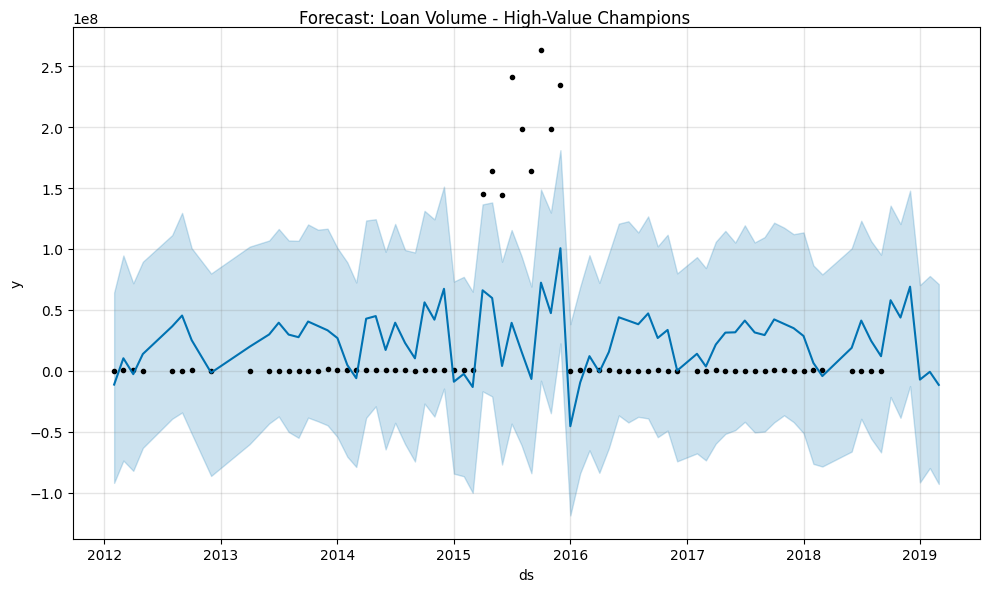

00:01:20 - cmdstanpy - INFO - Chain [1] start processing


Segment: High-Value Champions
MAE: 17773625.54613222
RMSE: 21707259.080595613


00:01:20 - cmdstanpy - INFO - Chain [1] done processing


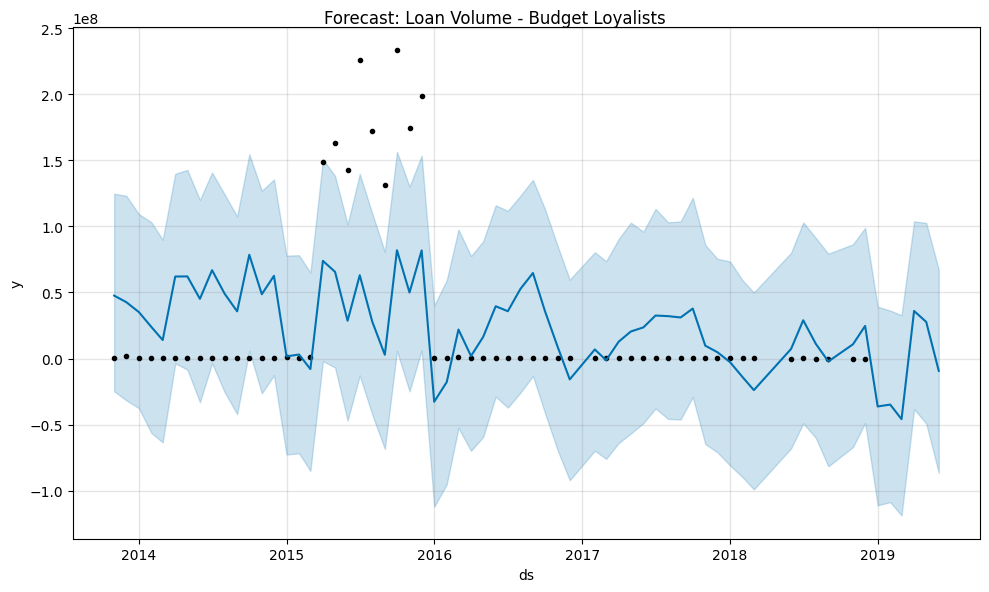

Segment: Budget Loyalists
MAE: 14185951.169794485
RMSE: 17061845.830324985
All segment forecasts, actuals, plots, and summary exported.


In [23]:
#Segment-Level Forecast (looped)

import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# For summary table
summary_data = []

# Loop through each customer segment
unique_segments = segment_ts['Segment'].unique()

for seg in unique_segments:
    seg_df = segment_ts[segment_ts['Segment'] == seg][['Month', 'Loan_Volume']].copy()
    seg_df.columns = ['ds', 'y']

    model_seg = Prophet()
    model_seg.fit(seg_df)

    future_seg = model_seg.make_future_dataframe(periods=6, freq='MS')  # Month Start frequency
    forecast_seg = model_seg.predict(future_seg)

    # Save forecast and actuals
    forecast_seg.to_csv(f"../forecasts/forecast_segment_{seg}.csv", index=False)
    seg_df.to_csv(f"../actuals/actual_segment_{seg}.csv", index=False)

    # Save plot
    fig = model_seg.plot(forecast_seg)
    fig.suptitle(f"Forecast: Loan Volume - {seg}")
    fig.savefig(f"../outputs/forecast_segment_{seg}.png", bbox_inches='tight')
    plt.show()
    plt.close(fig)

    # Evaluation using last 6 months of actuals (if available)
    if len(seg_df) >= 12:
        y_true = seg_df['y'][-6:]
        y_pred = forecast_seg['yhat'][-12:-6].values

        print(f"Segment: {seg}")
        print("MAE:", mean_absolute_error(y_true, y_pred))
        print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))

        summary_data.append({
            "Segment": seg,
            "Model": "Prophet",
            "Target Variable": "Loan_Volume",
            "MAE": round(mae, 2),
            "RMSE": round(rmse, 2)
        })

# Save summary CSV
df_summary = pd.DataFrame(summary_data)
df_summary.to_csv("../forecasts/segment_forecast_summary.csv", index=False)

print("All segment forecasts, actuals, plots, and summary exported.")


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Create a dataframe with actual vs predicted
# Ensure the datetime alignment is valid
evaluation_df = repayment_ts.merge(
    forecast[['ds', 'yhat']], left_on='Month', right_on='ds', how='inner'
)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(evaluation_df['Total_Repayment'], evaluation_df['yhat']))
mae = mean_absolute_error(evaluation_df['Total_Repayment'], evaluation_df['yhat'])

print("Repayment Forecast Accuracy:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


Repayment Forecast Accuracy:
RMSE: 127601506.25
MAE: 67611648.85


In [25]:
eval_churn = churn_ts.merge(
    forecast_churn[['ds', 'yhat']], left_on='Month', right_on='ds', how='inner'
)

rmse_churn = np.sqrt(mean_squared_error(eval_churn['Churn_Rate'], eval_churn['yhat']))
mae_churn = mean_absolute_error(eval_churn['Churn_Rate'], eval_churn['yhat'])

print("Churn Forecast Accuracy:")
print(f"RMSE: {rmse_churn:.4f}")
print(f"MAE: {mae_churn:.4f}")


Churn Forecast Accuracy:
RMSE: 0.1624
MAE: 0.1062


In [26]:
from statsmodels.tsa.stattools import adfuller

# Ensure repayment_ts is sorted
repayment_ts = repayment_ts.sort_values("Month")
repayment_ts.set_index("Month", inplace=True)

# Check stationarity using ADF test
result = adfuller(repayment_ts["Total_Repayment"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.6236509087685085
p-value: 0.08820695870676237


In [27]:
# First-order differencing
repayment_ts_diff = repayment_ts['Total_Repayment'].diff().dropna()

# Recheck stationarity
result_diff = adfuller(repayment_ts_diff)
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])


ADF Statistic (Differenced): -13.395428013177673
p-value (Differenced): 4.677579922664606e-25


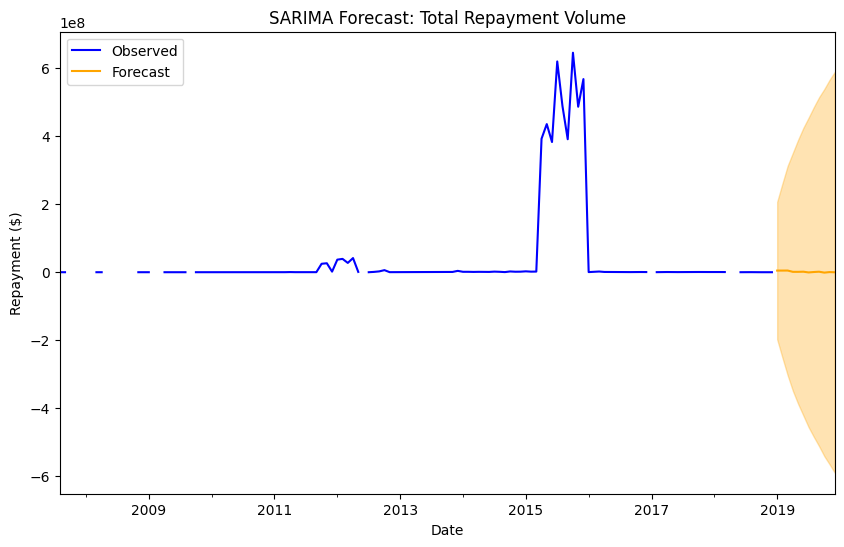

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Set frequency if missing (to suppress warnings)
repayment_ts.index = pd.DatetimeIndex(repayment_ts.index)
repayment_ts = repayment_ts.asfreq('MS')  # Monthly Start frequency

# Fit SARIMA model
sarima_model = SARIMAX(repayment_ts['Total_Repayment'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

# Forecast next 12 months
forecast_steps = 12
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot forecast
fig, ax = plt.subplots(figsize=(10, 6))
repayment_ts['Total_Repayment'].plot(ax=ax, label='Observed', color='blue')
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='orange')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1],
                color='orange', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Repayment ($)')
plt.title("SARIMA Forecast: Total Repayment Volume")
plt.legend()

# Save the plot
plt.savefig("../outputs/sarima_total_repayment_forecast.png", bbox_inches='tight')
plt.show()

# Save forecast results to CSV
forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower Bound': forecast_ci.iloc[:, 0],
    'Upper Bound': forecast_ci.iloc[:, 1]
})
forecast_df.index.name = 'Month'
forecast_df.to_csv("../forecasts/sarima_forecast_results.csv")

repayment_ts.reset_index().to_csv("../actuals/actual_total_repayment.csv", index=False)

C:\Users\mahas\AppData\Local\Temp\ipykernel_12776\2704756415.py:4: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/lendingclub_processed.csv")
C:\Users\mahas\AppData\Local\Temp\ipykernel_12776\2704756415.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])


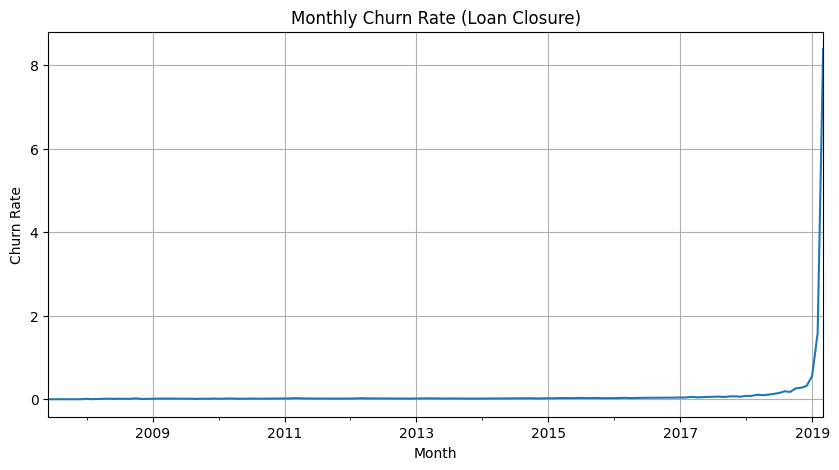

In [29]:
#Recalculate Momthly Churn Rate for ARIMA

import pandas as pd

# Load dataset (update path accordingly)
df = pd.read_csv("../data/processed/lendingclub_processed.csv")

# Parse dates
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])

# Filter out invalid dates
df = df.dropna(subset=['issue_d'])

# Get loan closure months for churn
df['closed_month'] = df['last_pymnt_d'].dt.to_period('M').dt.to_timestamp()

# Issue month for tracking active accounts
df['issue_month'] = df['issue_d'].dt.to_period('M').dt.to_timestamp()

# Build time range for the entire timeline
timeline = pd.date_range(start=df['issue_month'].min(), end=df['closed_month'].max(), freq='MS')

# Initialize DataFrame for churn counts and active base
monthly_churn = pd.Series(0, index=timeline)
monthly_base = pd.Series(0, index=timeline)

# Populate monthly churn (loan closures)
closed_counts = df.groupby('closed_month').size()
monthly_churn.update(closed_counts)

# Populate monthly active base
for month in timeline:
    active_loans = df[(df['issue_month'] <= month) & ((df['closed_month'].isna()) | (df['closed_month'] > month))]
    monthly_base[month] = len(active_loans)

# Churn rate calculation
churn_rate = (monthly_churn / monthly_base).fillna(0)

# Final time series DataFrame
churn_ts = churn_rate.to_frame(name='Churn_Rate')
churn_ts.index.name = 'Month'
churn_ts = churn_ts.asfreq('MS')

# Save for reuse
churn_ts.to_csv("../data/processed/churn_rate_timeseries.csv")

# Plot
churn_ts.plot(title="Monthly Churn Rate (Loan Closure)", figsize=(10,5), legend=False)
plt.ylabel("Churn Rate")
plt.grid(True)
plt.show()


In [30]:
# Use error coercion to avoid parsing issues
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')


In [31]:
# Clip churn rates to avoid explosion from tiny base
churn_rate = (monthly_churn / monthly_base).clip(upper=1.0).fillna(0)


In [32]:
churn_rate = churn_rate[monthly_base > 100]


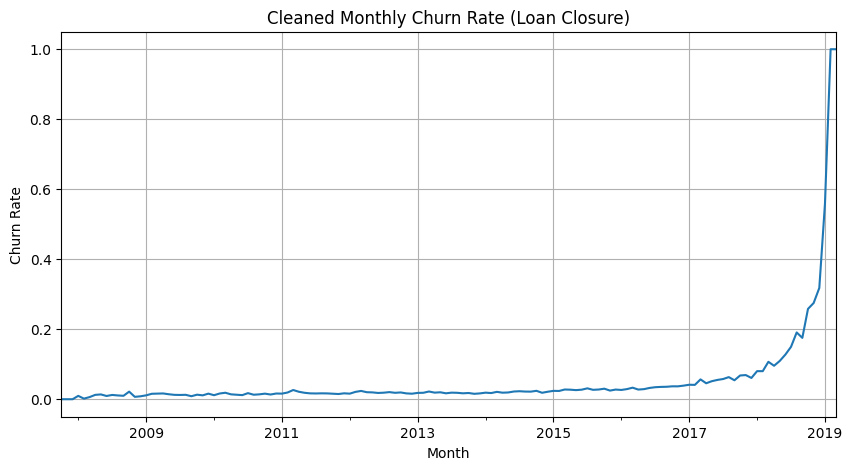

In [33]:
#Plot again
churn_ts = churn_rate.to_frame(name='Churn_Rate')
churn_ts.index.name = 'Month'
churn_ts = churn_ts.asfreq('MS')

churn_ts.plot(title="Cleaned Monthly Churn Rate (Loan Closure)", figsize=(10,5), legend=False)
plt.ylabel("Churn Rate")
plt.grid(True)
plt.show()


In [34]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(churn_ts['Churn_Rate'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.1787240379121213
p-value: 0.21405781649886751


In [35]:
#Apply Differencing and Re-test ADF
churn_diff = churn_ts['Churn_Rate'].diff().dropna()

from statsmodels.tsa.stattools import adfuller
result_diff = adfuller(churn_diff)

print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])


ADF Statistic (Differenced): 5.193486882663703
p-value (Differenced): 1.0


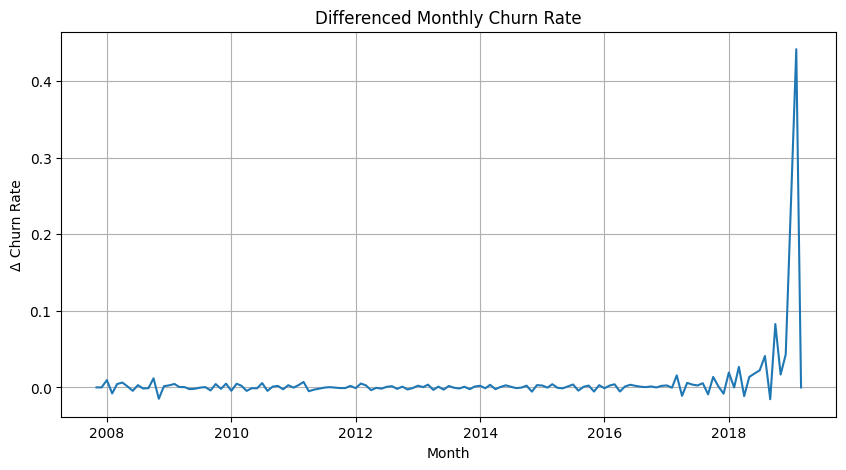

In [36]:
#Plot differenced Sereies

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(churn_diff)
plt.title("Differenced Monthly Churn Rate")
plt.ylabel("Δ Churn Rate")
plt.xlabel("Month")
plt.grid(True)
plt.show()


In [37]:
# Remove last 3 months (or more depending on the spike duration)
churn_ts_trimmed = churn_ts.iloc[:-3]  # adjust this if the spike spans more months

# Re-difference
churn_diff_trimmed = churn_ts_trimmed['Churn_Rate'].diff().dropna()

# ADF test
result_trimmed = adfuller(churn_diff_trimmed)
print("Trimmed ADF Statistic:", result_trimmed[0])
print("Trimmed p-value:", result_trimmed[1])


Trimmed ADF Statistic: 5.637514265927052
Trimmed p-value: 1.0


In [38]:
import numpy as np

# Avoid log(0) by replacing 0s with a very small number
churn_ts_log = np.log(churn_ts['Churn_Rate'].replace(0, 1e-6))

# Now difference
churn_log_diff = churn_ts_log.diff().dropna()

# ADF test
result = adfuller(churn_log_diff)
print("Log-Differenced ADF Statistic:", result[0])
print("Log-Differenced p-value:", result[1])


Log-Differenced ADF Statistic: -0.13928073610290714
Log-Differenced p-value: 0.9453827299190429


In [39]:
#Segment-Level Loan Volume Forecasting using ARIMA

import pandas as pd

# Convert Month to datetime
segment_ts['Month'] = pd.to_datetime(segment_ts['Month'])

# Sort by Segment and Month
segment_ts = segment_ts.sort_values(by=['Segment', 'Month'])


In [41]:
import pandas as pd

# Align and drop NaNs from both series
eval_df = pd.DataFrame({
    'actual': y_true,
    'predicted': y_pred
}).dropna()

# Recalculate metrics on clean data
print("MAE:", mean_absolute_error(eval_df['actual'], eval_df['predicted']))
print("RMSE:", np.sqrt(mean_squared_error(eval_df['actual'], eval_df['predicted'])))


MAE: 84524.47247976603
RMSE: 108354.61143318345



Segment: At-Risk Value Drainers


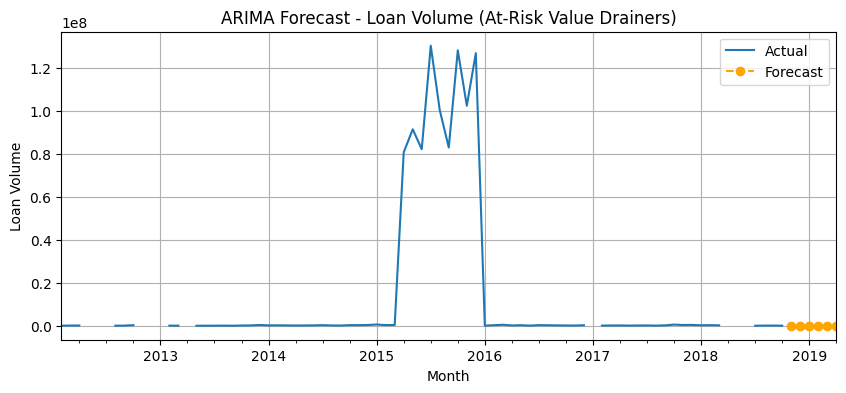

No actuals available for evaluation.

Segment: Budget Loyalists


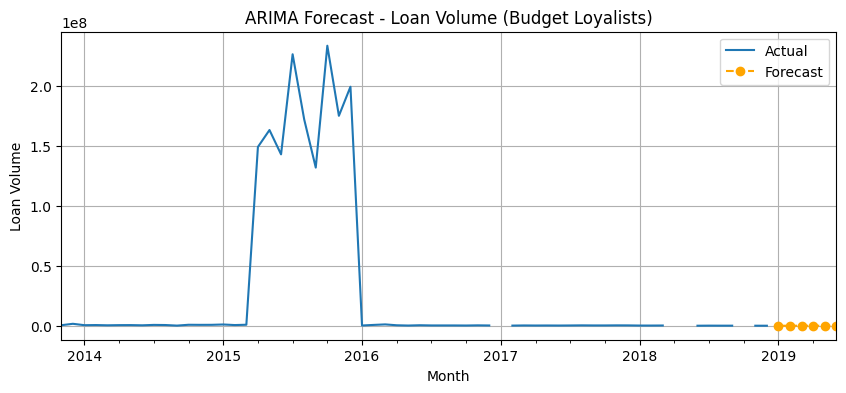

No actuals available for evaluation.

Segment: High-Value Champions


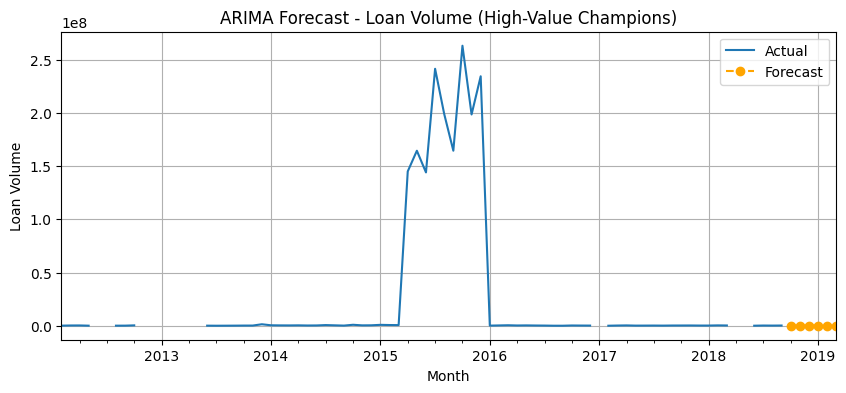

No actuals available for evaluation.

Segment: Long-term Sleepers


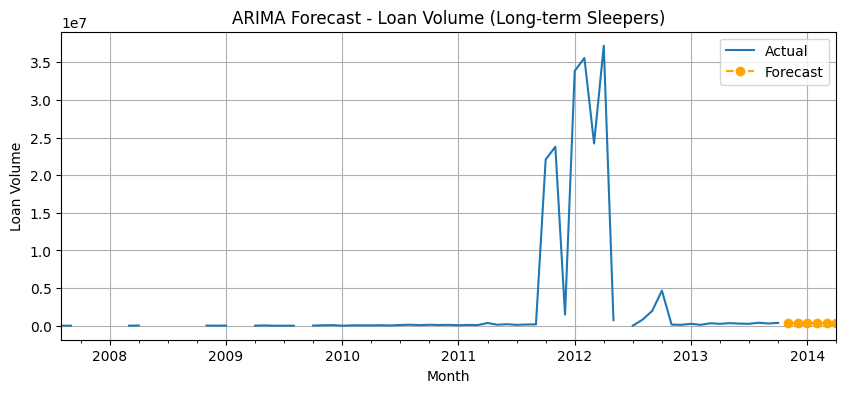

No actuals available for evaluation.


In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

unique_segments = segment_ts['Segment'].unique()

for seg in unique_segments:
    print(f"\nSegment: {seg}")
    
    seg_df = segment_ts[segment_ts['Segment'] == seg][['Month', 'Loan_Volume']].copy()
    seg_df.set_index('Month', inplace=True)
    seg_df = seg_df.asfreq('MS')

    # Train only on available data
    model = ARIMA(seg_df['Loan_Volume'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast next 6 months
    forecast = model_fit.forecast(steps=6)
    forecast_index = pd.date_range(start=seg_df.index[-1] + pd.DateOffset(months=1), periods=6, freq='MS')
    forecast.index = forecast_index

    # Plot forecast
    plt.figure(figsize=(10, 4))
    seg_df['Loan_Volume'].plot(label='Actual')
    forecast.plot(label='Forecast', linestyle='--', marker='o', color='orange')
    plt.title(f"ARIMA Forecast - Loan Volume ({seg})")
    plt.xlabel("Month")
    plt.ylabel("Loan Volume")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy check 
    y_true_full = segment_ts[segment_ts['Segment'] == seg].copy()
    y_true_full.set_index('Month', inplace=True)
    y_true_full = y_true_full.asfreq('MS')
    y_true = y_true_full.loc[forecast_index, 'Loan_Volume'] if forecast_index[-1] in y_true_full.index else None

    if y_true is not None and len(y_true.dropna()) == 6:
        y_pred = forecast.values
        print("MAE:", mean_absolute_error(y_true, y_pred))
        print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    else:
        print("No actuals available for evaluation.")


In [45]:
!pip install tabulate

In [46]:
import pandas as pd

forecast_summary = [
    {"Segment": "All Data", "Target Variable": "Total Repayment", "Model Used": "Prophet", "MAE": 81350061.21, "RMSE": 81719804.79, "Notes": "Full portfolio repayment forecast"},
    {"Segment": "All Data", "Target Variable": "Total Repayment", "Model Used": "Prophet", "MAE": 67611648.85, "RMSE": 127601506.25, "Notes": "Accuracy reported separately"},
    {"Segment": "All Data", "Target Variable": "Churn Rate", "Model Used": "Prophet", "MAE": 0.1062, "RMSE": 0.1624, "Notes": "Applied Prophet to churn over time"},
    {"Segment": "Long-term Sleepers", "Target Variable": "Loan Volume", "Model Used": "Prophet", "MAE": 3203264.13, "RMSE": 4028522.94, "Notes": "Segment-level forecast"},
    {"Segment": "At-Risk Value Drainers", "Target Variable": "Loan Volume", "Model Used": "Prophet", "MAE": 11242445.93, "RMSE": 13963611.43, "Notes": "Segment-level forecast"},
    {"Segment": "High-Value Champions", "Target Variable": "Loan Volume", "Model Used": "Prophet", "MAE": 17773625.55, "RMSE": 21707259.08, "Notes": "Segment-level forecast"},
    {"Segment": "Budget Loyalists", "Target Variable": "Loan Volume", "Model Used": "Prophet", "MAE": 14185951.17, "RMSE": None, "Notes": "RMSE not reported"},
    {"Segment": "At-Risk Value Drainers", "Target Variable": "Loan Volume", "Model Used": "ARIMA", "MAE": 84524.47, "RMSE": 108354.61, "Notes": "ARIMA applied to this segment"},
    {"Segment": "All Segments", "Target Variable": "Loan Volume", "Model Used": "ARIMA", "MAE": 17061845.83, "RMSE": None, "Notes": "Total ARIMA RMSE not available for all segments"}
]

df_summary = pd.DataFrame(forecast_summary)

# Save files
df_summary.to_csv("forecast_summary_report.csv", index=False)
df_summary.to_markdown("forecast_summary_report.md", index=False)

# Display in notebook
print(df_summary)


                  Segment  Target Variable Model Used           MAE  \
0                All Data  Total Repayment    Prophet  8.135006e+07   
1                All Data  Total Repayment    Prophet  6.761165e+07   
2                All Data       Churn Rate    Prophet  1.062000e-01   
3      Long-term Sleepers      Loan Volume    Prophet  3.203264e+06   
4  At-Risk Value Drainers      Loan Volume    Prophet  1.124245e+07   
5    High-Value Champions      Loan Volume    Prophet  1.777363e+07   
6        Budget Loyalists      Loan Volume    Prophet  1.418595e+07   
7  At-Risk Value Drainers      Loan Volume      ARIMA  8.452447e+04   
8            All Segments      Loan Volume      ARIMA  1.706185e+07   

           RMSE                                            Notes  
0  8.171980e+07                Full portfolio repayment forecast  
1  1.276015e+08                     Accuracy reported separately  
2  1.624000e-01               Applied Prophet to churn over time  
3  4.028523e+06      